In [158]:
# Libraries
import pyforest
import datetime
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


os.chdir("E:/3. Hacker Earth/Logistics")

<IPython.core.display.Javascript object>

In [159]:
# Dataset
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [160]:
df_train.shape, df_test.shape

((6500, 20), (3500, 19))

In [161]:
df_train = df_train.drop(['Customer Id','Artist Name'], axis = 1)
df_test = df_test.drop(['Customer Id','Artist Name'], axis = 1)

In [162]:
df_train.columns

Index(['Artist Reputation', 'Height', 'Width', 'Weight', 'Material',
       'Price Of Sculpture', 'Base Shipping Price', 'International',
       'Express Shipment', 'Installation Included', 'Transport', 'Fragile',
       'Customer Information', 'Remote Location', 'Scheduled Date',
       'Delivery Date', 'Customer Location', 'Cost'],
      dtype='object')

### NULL Check

In [163]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Artist Reputation      5750 non-null   float64
 1   Height                 6125 non-null   float64
 2   Width                  5916 non-null   float64
 3   Weight                 5913 non-null   float64
 4   Material               5736 non-null   object 
 5   Price Of Sculpture     6500 non-null   float64
 6   Base Shipping Price    6500 non-null   float64
 7   International          6500 non-null   object 
 8   Express Shipment       6500 non-null   object 
 9   Installation Included  6500 non-null   object 
 10  Transport              5108 non-null   object 
 11  Fragile                6500 non-null   object 
 12  Customer Information   6500 non-null   object 
 13  Remote Location        5729 non-null   object 
 14  Scheduled Date         6500 non-null   object 
 15  Deli

In [164]:
df_train.isnull().sum()

Artist Reputation         750
Height                    375
Width                     584
Weight                    587
Material                  764
Price Of Sculpture          0
Base Shipping Price         0
International               0
Express Shipment            0
Installation Included       0
Transport                1392
Fragile                     0
Customer Information        0
Remote Location           771
Scheduled Date              0
Delivery Date               0
Customer Location           0
Cost                        0
dtype: int64

### Imputation

In [165]:
null_numerical = ["Artist Reputation","Height","Width","Weight"]
null_categorical = ["Material","Transport","Remote Location"]

In [166]:
for i in null_numerical:
    df_train.fillna(df_train[i].median(),inplace = True)
    df_test.fillna(df_test[i].median(),inplace = True)

In [167]:
most_common = []

def most_common_term(data,feature):
    return data[feature].value_counts().index[0]

for i in null_categorical:
    most_common.append(most_common_term(df_train,i))
    
most_common

['Brass', 'Roadways', 'No']

In [168]:
k = 0

for i in null_categorical:
    df_train.fillna(most_common[k],inplace = True)
    df_test.fillna(most_common[k],inplace = True)

In [169]:
df_train.isnull().sum().sum()

0

### Data Manipulation


In [170]:
# Get State from Customer Location
df_train["State"] = df_train["Customer Location"].apply(lambda x: x.split(" ")[-2])
df_test["State"] = df_test["Customer Location"].apply(lambda x: x.split(" ")[-2])

In [171]:
# Remove Customer Location
df_train = df_train.drop(['Customer Location'], axis = 1)
df_test = df_test.drop(['Customer Location'], axis = 1)

In [172]:
# Coverting obj to date
df_train['Scheduled Date']= pd.to_datetime(df_train['Scheduled Date'])
df_test['Scheduled Date']= pd.to_datetime(df_test['Scheduled Date'])

df_train['Delivery Date']= pd.to_datetime(df_train['Delivery Date'])
df_test['Delivery Date']= pd.to_datetime(df_test['Delivery Date'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [173]:
# Max data -> Schedule date
# Min data -> Delivery date
df_train['Scheduled Date 1'] = df_train[['Scheduled Date', 'Delivery Date']].min(axis=1)
df_test['Scheduled Date 1'] = df_test[['Scheduled Date', 'Delivery Date']].min(axis=1)

df_train['Delivery Date 1'] = df_train[['Scheduled Date', 'Delivery Date']].max(axis=1)
df_test['Delivery Date 1'] = df_test[['Scheduled Date', 'Delivery Date']].max(axis=1)

# assigning the new dates to original cols
df_train['Scheduled Date'] = df_train['Scheduled Date 1']
df_test['Scheduled Date'] = df_test['Scheduled Date 1']

df_train['Delivery Date'] = df_train['Delivery Date 1']
df_test['Delivery Date'] = df_test['Delivery Date 1']

# Remove duplicate date cols
df_train = df_train.drop(['Scheduled Date 1','Delivery Date 1'], axis = 1)
df_test = df_test.drop(['Scheduled Date 1','Delivery Date 1'], axis = 1)

In [174]:
# Delivery Days
df_train['Delivery Days'] = (df_train['Delivery Date'] - df_train['Scheduled Date']).dt.days
df_test['Delivery Days'] = (df_test['Delivery Date'] - df_test['Scheduled Date']).dt.days

# Month 
df_train['month_of_delivery'] = df_train['Delivery Date'].dt.month_name()
df_test['month_of_delivery'] = df_test['Delivery Date'].dt.month_name()

In [175]:
# Month 
df_train['Year'] = df_train['Delivery Date'].dt.year
df_test['Year'] = df_test['Delivery Date'].dt.year

In [176]:
# Weekday/end
df_train['week_day_end'] = df_train['Delivery Date'].dt.day_name()
df_train['week_day_end'] = df_train['week_day_end'].apply(lambda x: 'weekend' if x in ("Saturday","Sunday") else 'weekday')

df_test['week_day_end'] = df_test['Delivery Date'].dt.day_name()
df_test['week_day_end'] = df_test['week_day_end'].apply(lambda x: 'weekend' if x in ("Saturday","Sunday") else 'weekday')

In [177]:
# get abs value of cost
df_train['Cost'] = df_train['Cost'].abs()

In [178]:
df_test.head(2)

Artist Reputation  Height  Width  Weight Material  Price Of Sculpture  \
0               0.35    53.0   18.0   871.0     Wood                5.98   
1               0.67     7.0    4.0   108.0     Clay                6.92   

   Base Shipping Price International Express Shipment Installation Included  \
0                19.11           Yes              Yes                    No   
1                13.96            No               No                    No   

   ... Fragile Customer Information Remote Location Scheduled Date  \
0  ...      No        Working Class              No     2017-07-03   
1  ...     Yes        Working Class              No     2016-05-02   

  Delivery Date State Delivery Days  month_of_delivery  Year  week_day_end  
0    2017-07-06    IA             3               July  2017       weekday  
1    2016-05-02    OH             0                May  2016       weekday  

[2 rows x 21 columns]

In [179]:
# test and train merged
data = pd.concat([df_train,df_test],axis = 0)

<IPython.core.display.Javascript object>

In [180]:
data.tail(2)

Artist Reputation  Height  Width    Weight   Material  \
3498               0.45    17.0    9.0     565.0  Aluminium   
3499               0.97    25.0   11.0  989903.0      Stone   

      Price Of Sculpture  Base Shipping Price International Express Shipment  \
3498                6.75                10.89            No              Yes   
3499             4768.42                31.38            No              Yes   

     Installation Included  ... Customer Information Remote Location  \
3498                   Yes  ...              Wealthy              No   
3499                    No  ...        Working Class              No   

     Scheduled Date Delivery Date Cost State  Delivery Days month_of_delivery  \
3498     2017-06-28    2017-06-28  NaN    UT              0              June   
3499     2019-02-15    2019-02-19  NaN    KY              4          February   

      Year week_day_end  
3498  2017      weekday  
3499  2019      weekday  

[2 rows x 22 columns]

### One Hot Coding

In [181]:
# Categorical Features
features = ["Material","International","Express Shipment","Installation Included","Transport","Fragile","Customer Information","Remote Location","State","month_of_delivery",'Year',"week_day_end"]

In [182]:
# One Hot Encoding
encoder = OneHotEncoder(drop='first')
encoder.fit(data[features].astype(str))

df_train_ohe = encoder.transform(df_train[features].astype(str)).toarray()
df_test_ohe = encoder.transform(df_test[features].astype(str)).toarray()

df_train_column_name = encoder.get_feature_names(features)
df_test_column_name = encoder.get_feature_names(features)

<IPython.core.display.Javascript object>

In [183]:
# Creating Dataframe
df_train_ohe =  pd.DataFrame(df_train_ohe, columns= df_train_column_name)
df_test_ohe =  pd.DataFrame(df_test_ohe, columns= df_test_column_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [184]:
df_train_add = pd.concat([df_train[df_train.columns.difference(features)], df_train_ohe], axis = 1)
df_test_add = pd.concat([df_test[df_test.columns.difference(features)], df_test_ohe], axis = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [185]:
df_test_add.columns

Index(['Artist Reputation', 'Base Shipping Price', 'Delivery Date',
       'Delivery Days', 'Height', 'Price Of Sculpture', 'Scheduled Date',
       'Weight', 'Width', 'Material_Aluminium', 'Material_Brass',
       'Material_Bronze', 'Material_Clay', 'Material_Marble', 'Material_Stone',
       'Material_Wood', 'International_Yes', 'Express Shipment_Yes',
       'Installation Included_Yes', 'Transport_Airways', 'Transport_Roadways',
       'Transport_Waterways', 'Fragile_Yes',
       'Customer Information_Working Class', 'Remote Location_No',
       'Remote Location_Yes', 'State_AE', 'State_AK', 'State_AL', 'State_AP',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'St

In [186]:
df_train_add = df_train_add.drop(['Scheduled Date','Delivery Date'], axis = 1)
df_test_add = df_test_add.drop(['Scheduled Date','Delivery Date'], axis = 1)

### Normalization

In [187]:
df_train_add

Artist Reputation  Base Shipping Price         Cost  Delivery Days  \
0                  0.26                16.27       283.29              4   
1                  0.28                15.00       159.96              1   
2                  0.07                21.18       154.29              1   
3                  0.12                16.31       161.16              4   
4                  0.15                11.94       159.23              4   
5                  0.99                16.88      1922.78              2   
6                  0.64                90.67      1536.66              3   
7                  0.74                13.25       422.42              4   
8                  0.00                19.76       160.10              4   
9                  0.12                49.25       834.27              4   
10                 0.14                85.09       652.66              2   
11                 0.29                56.04      4106.98              0   
12                 0.26                20.72       190.08              2   
13                 0.54                17.55       334.98              1   
14                 0.69                16.43       359.72              3   
15                 0.72                84.38     88316.02              2   
16                 0.27                28.18       329.20              3   
17                 0.10                64.64      1924.30              1   
18                 0.11                82.84       425.64              4   
19                 0.54                86.65      1354.11              2   
20                 0.59                15.76       318.74              3   
21                 0.11                46.56       708.99              0   
22                 0.66                10.48       244.61              3   
23                 0.57                30.87     39680.72              2   
24                 0.43                91.58      2296.74              0   
25                 0.45                19.61       279.16              3   
26                 0.20                93.59       547.81              1   
27                 0.47                19.83       371.82              4   
28                 0.51                59.22      1087.36              0   
29                 0.67                11.04       280.22              1   
30                 0.56                99.06      1358.73              4   
31                 0.25                18.35       358.92              3   
32                 0.31                24.67       214.15              0   
33                 0.57                22.24       241.48              0   
34                 0.01                22.49       128.38              3   
35                 0.68                20.36       280.42              1   
36                 0.23                13.82       179.32              3   
37                 0.52                17.00       288.58              4   
38                 0.59                89.55      4895.23              0   
39                 0.01                22.03       156.30              1   
40                 0.93                78.75      2944.95              0   
41                 0.58                19.83       205.19              2   
42                 0.86                81.85      5364.93              2   
43                 0.27                15.04       181.02              0   
44                 0.17                11.07       152.23              1   
45                 0.54                48.17      1731.53              4   
46                 0.07                11.75       137.87              2   
47                 0.51                23.85       263.23              3   
48                 0.59                19.77       380.91              1   
49                 0.29                15.80       300.68              4   
50                 0.17                63.79       392.20              0   
51                 0.60                92.44      5651

In [188]:
from scipy import stats
index_to_remove = df_train_add[(np.abs(stats.zscore(df_train_add)) < 3).all(axis=1)].index

<IPython.core.display.Javascript object>

In [189]:
index_to_remove

Int64Index([  33,   40,  315,  678, 1231, 1239, 1347, 1683, 1828, 2045, 2559,
            3009, 3461, 3542, 3570, 3861, 4002, 4991, 5828, 6169, 6224],
           dtype='int64')

In [190]:
df_train_add.shape

(6500, 94)

In [191]:
df_train_add = df_train_add[~df_train_add.index.isin(index_to_remove)]

In [192]:
df_train_add.shape

(6479, 94)

### EDA

<IPython.core.display.Javascript object>

{'whiskers': [<matplotlib.lines.Line2D at 0x23e879a9cc8>,
 'caps': [<matplotlib.lines.Line2D at 0x23e879a9308>,
 'boxes': [<matplotlib.lines.Line2D at 0x23eeb67d348>],
 'medians': [<matplotlib.lines.Line2D at 0x23e87819648>],
 'fliers': [<matplotlib.lines.Line2D at 0x23e87819a08>],
 'means': []}

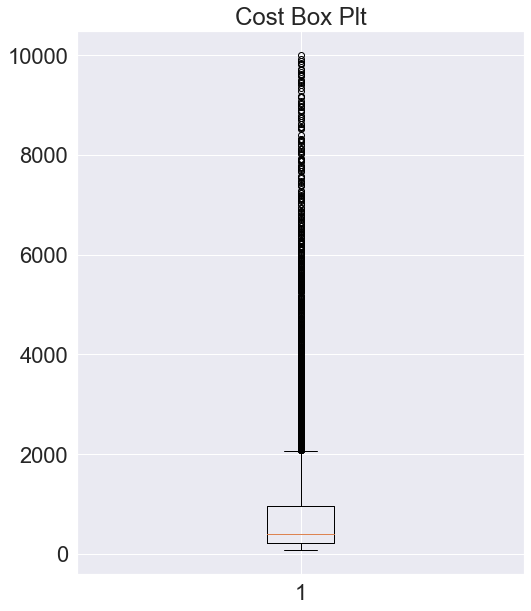

In [193]:
df_train_add_1 = df_train_add.copy()
df_train_add_1 = df_train_add_1[df_train_add_1["Cost"] < 10000]
fig1, ax1 = plt.subplots()
ax1.set_title('Cost Box Plt')
ax1.boxplot(df_train_add_1['Cost'])

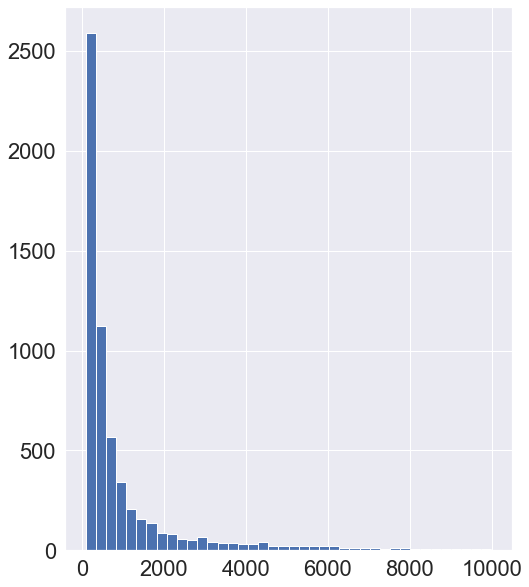

In [194]:
df_train_add_1['Cost'].hist(bins = 40)

<IPython.core.display.Javascript object>

{'whiskers': [<matplotlib.lines.Line2D at 0x23eebe61f08>,
 'caps': [<matplotlib.lines.Line2D at 0x23eebe64d08>,
 'boxes': [<matplotlib.lines.Line2D at 0x23eebe61988>],
 'medians': [<matplotlib.lines.Line2D at 0x23eebe64e88>],
 'fliers': [<matplotlib.lines.Line2D at 0x23eebe6ad48>],
 'means': []}

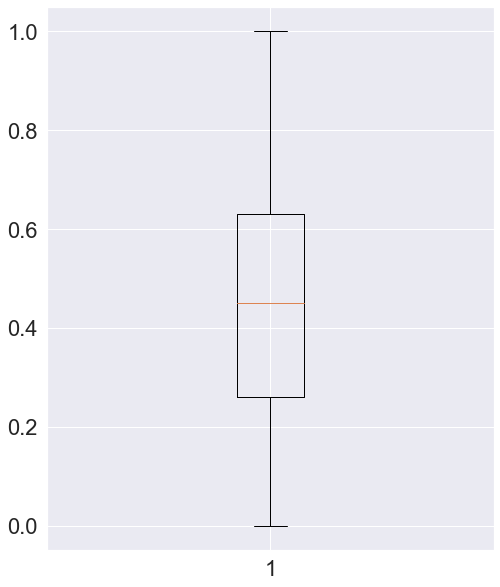

In [195]:
fig1, ax1 = plt.subplots()
ax1.boxplot(df_train_add_1['Artist Reputation'])

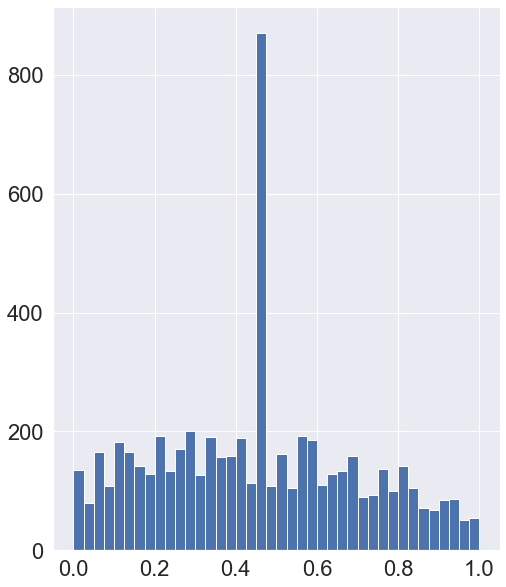

In [196]:
df_train_add_1['Artist Reputation'].hist(bins = 40)

In [197]:
df_train_add_1 = df_train_add_1[df_train_add_1["Artist Reputation"] != max(df_train_add_1["Artist Reputation"])]

In [198]:
df_train_add_1 = df_train_add_1[df_train_add_1["Price Of Sculpture"] != max(df_train_add_1["Price Of Sculpture"])]

In [199]:
df_train_add_1.shape

(5964, 94)

<IPython.core.display.Javascript object>

{'whiskers': [<matplotlib.lines.Line2D at 0x23e8af46fc8>,
 'caps': [<matplotlib.lines.Line2D at 0x23e8af41a88>,
 'boxes': [<matplotlib.lines.Line2D at 0x23e8af46688>],
 'medians': [<matplotlib.lines.Line2D at 0x23e8af4bf48>],
 'fliers': [<matplotlib.lines.Line2D at 0x23e8af4bfc8>],
 'means': []}

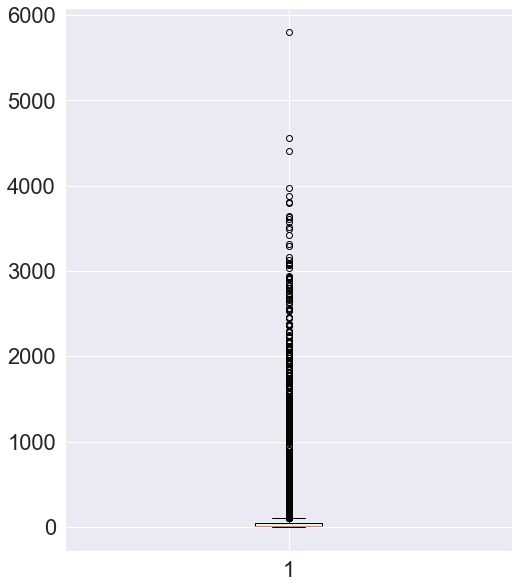

In [200]:
fig1, ax1 = plt.subplots()
ax1.boxplot(df_train_add_1['Price Of Sculpture'])

In [201]:
df_train_add_1 = df_train_add_1[df_train_add_1["Weight"] < 5000]

<IPython.core.display.Javascript object>

{'whiskers': [<matplotlib.lines.Line2D at 0x23e8afcec88>,
 'caps': [<matplotlib.lines.Line2D at 0x23e8afcabc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x23e878befc8>],
 'medians': [<matplotlib.lines.Line2D at 0x23e8afc4b48>],
 'fliers': [<matplotlib.lines.Line2D at 0x23e8afc4c48>],
 'means': []}

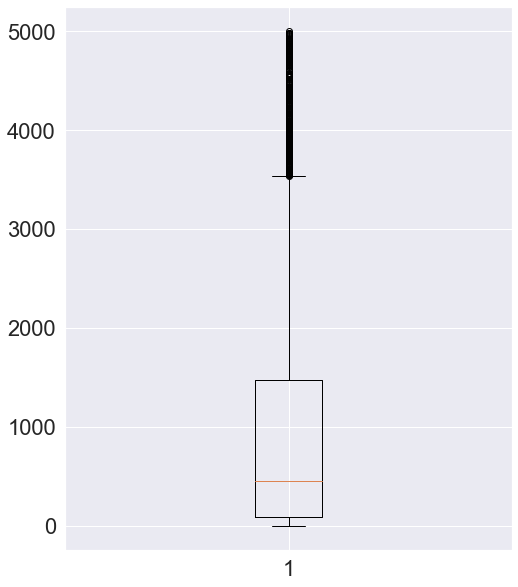

In [202]:
fig1, ax1 = plt.subplots()
ax1.boxplot(df_train_add_1['Weight'])

<IPython.core.display.Javascript object>

{'whiskers': [<matplotlib.lines.Line2D at 0x23e87952e48>,
 'caps': [<matplotlib.lines.Line2D at 0x23e87965e08>,
 'boxes': [<matplotlib.lines.Line2D at 0x23e87952348>],
 'medians': [<matplotlib.lines.Line2D at 0x23e87945d88>],
 'fliers': [<matplotlib.lines.Line2D at 0x23e87945e88>],
 'means': []}

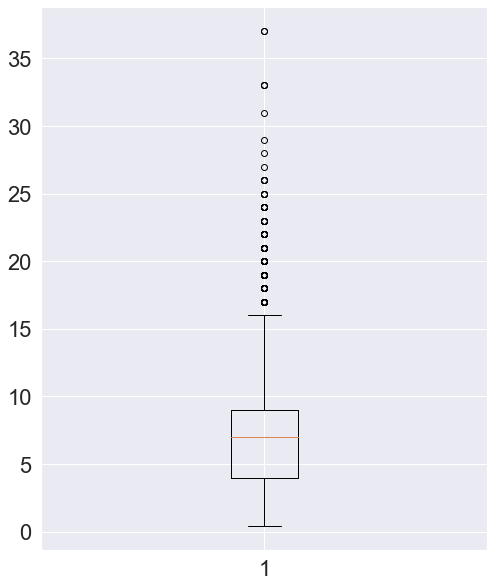

In [203]:
fig1, ax1 = plt.subplots()
ax1.boxplot(df_train_add_1['Width'])

In [204]:
df_train_add_1 = df_train_add_1[df_train_add_1["Base Shipping Price"] <= df_train_add_1["Cost"]]

In [205]:
df_train_add_1.shape

(3855, 94)

In [206]:
df_train_add = df_train_add_1

### Normalization

In [207]:
#df_train_add_cost = pd.DataFrame(df_train_add["Cost"])
#df_train_add = df_train_add.drop(['Cost'], axis = 1)
#scaler = preprocessing.Normalizer()
scaler = StandardScaler()
df_train_scaler = pd.DataFrame(scaler.fit_transform(df_train_add))
df_train_scaler.columns = df_train_add.columns

<IPython.core.display.Javascript object>

In [208]:
df_train_scaler.columns

Index(['Artist Reputation', 'Base Shipping Price', 'Cost', 'Delivery Days',
       'Height', 'Price Of Sculpture', 'Weight', 'Width', 'Material_Aluminium',
       'Material_Brass', 'Material_Bronze', 'Material_Clay', 'Material_Marble',
       'Material_Stone', 'Material_Wood', 'International_Yes',
       'Express Shipment_Yes', 'Installation Included_Yes',
       'Transport_Airways', 'Transport_Roadways', 'Transport_Waterways',
       'Fragile_Yes', 'Customer Information_Working Class',
       'Remote Location_No', 'Remote Location_Yes', 'State_AE', 'State_AK',
       'State_AL', 'State_AP', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
       'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI',
       'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
       'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN',
       'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE',
       'State_NH', 'State_NJ', 'State

In [209]:
df_train_scaler.head()

Artist Reputation  Base Shipping Price      Cost  Delivery Days    Height  \
0          -0.800023            -0.310126 -0.201509       1.432343  0.020395   
1          -0.719691            -0.413775 -0.391769      -0.675974 -1.203344   
2          -1.563183             0.090598 -0.400516      -0.675974 -0.766295   
3          -1.362351            -0.306861 -0.389918       1.432343 -0.678885   
4          -1.241852            -0.663514 -0.392895       1.432343  0.020395   

   Price Of Sculpture    Weight     Width  Material_Aluminium  Material_Brass  \
0           -0.062147  2.515166 -0.280522           -0.514955        3.059886   
1           -0.109059 -0.757961 -0.933274           -0.514955        3.059886   
2           -0.121450 -0.616316 -0.498106           -0.514955       -0.326810   
3           -0.115817 -0.806691 -1.488113            1.941916       -0.326810   
4           -0.133244 -0.546298 -0.280522            1.941916       -0.326810   

   ...  month_of_delivery_March  month_of_delivery_May  \
0  ...                -0.315008              -0.313513   
1  ...                 3.174521              -0.313513   
2  ...                 3.174521              -0.313513   
3  ...                -0.315008               3.189657   
4  ...                -0.315008              -0.313513   

   month_of_delivery_November  month_of_delivery_October  \
0                   -0.278781                  -0.270036   
1                   -0.278781                  -0.270036   
2                   -0.278781                  -0.270036   
3                   -0.278781                  -0.270036   
4                   -0.278781                  -0.270036   

   month_of_delivery_September  Year_2016  Year_2017  Year_2018  Year_2019  \
0                     -0.28201  -0.511325  -0.542672  -0.511325   -0.40012   
1                     -0.28201  -0.511325   1.842734  -0.511325   -0.40012   
2                     -0.28201  -0.511325  -0.542672  -0.511325   -0.40012   
3                     -0.28201  -0.511325  -0.542672  -0.511325   -0.40012   
4                     -0.28201   1.955705  -0.542672  -0.511325   -0.40012   

   week_day_end_weekend  
0              1.582576  
1             -0.631881  
2             -0.631881  
3              1.582576  
4              1.582576  

[5 rows x 94 columns]

Best alpha using built-in LassoCV: 7.664170
Best score using built-in LassoCV: 0.705683


<IPython.core.display.Javascript object>

Lasso picked 26 variables and eliminated the other 67 variables


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Feature importance using Lasso Model')

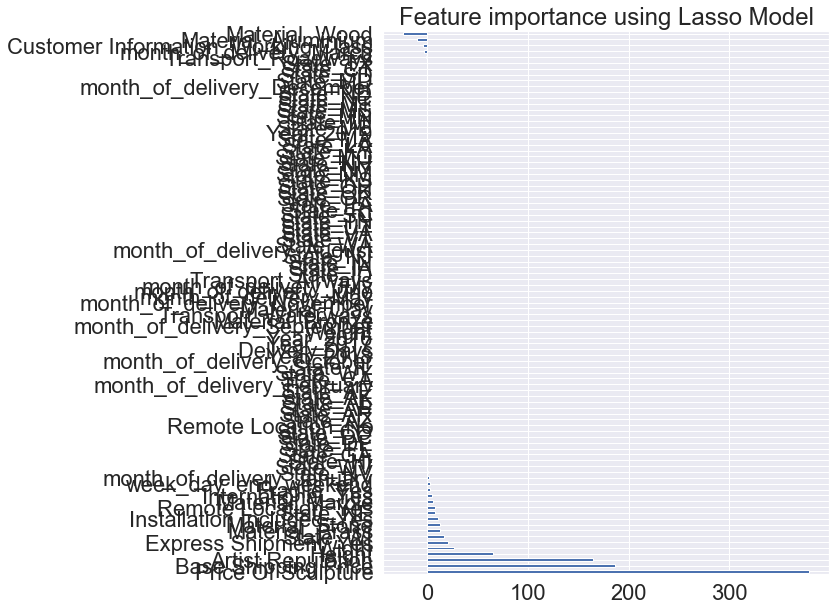

In [210]:

X = df_train_scaler.drop("Cost",1)   #Feature Matrix
y = df_train_add["Cost"]          #Target Variable

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values(ascending=False)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [211]:
imp_coef[0:26].index.shape

(26,)

In [212]:
# 1. Important Features 1
imp_features_1 = list(imp_coef[0:26].index)

In [213]:
imp_features_1.append("Cost")

In [214]:
imp_features_1

['Price Of Sculpture',
 'Base Shipping Price',
 'Artist Reputation',
 'Height',
 'Width',
 'Express Shipment_Yes',
 'State_WI',
 'Material_Brass',
 'Material_Stone',
 'Installation Included_Yes',
 'State_NE',
 'Remote Location_Yes',
 'Material_Marble',
 'International_Yes',
 'Fragile_Yes',
 'week_day_end_weekend',
 'month_of_delivery_January',
 'State_NV',
 'State_WV',
 'State_HI',
 'State_GA',
 'State_FL',
 'State_DE',
 'State_DC',
 'State_CO',
 'Remote Location_No',
 'Cost']

### Corr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

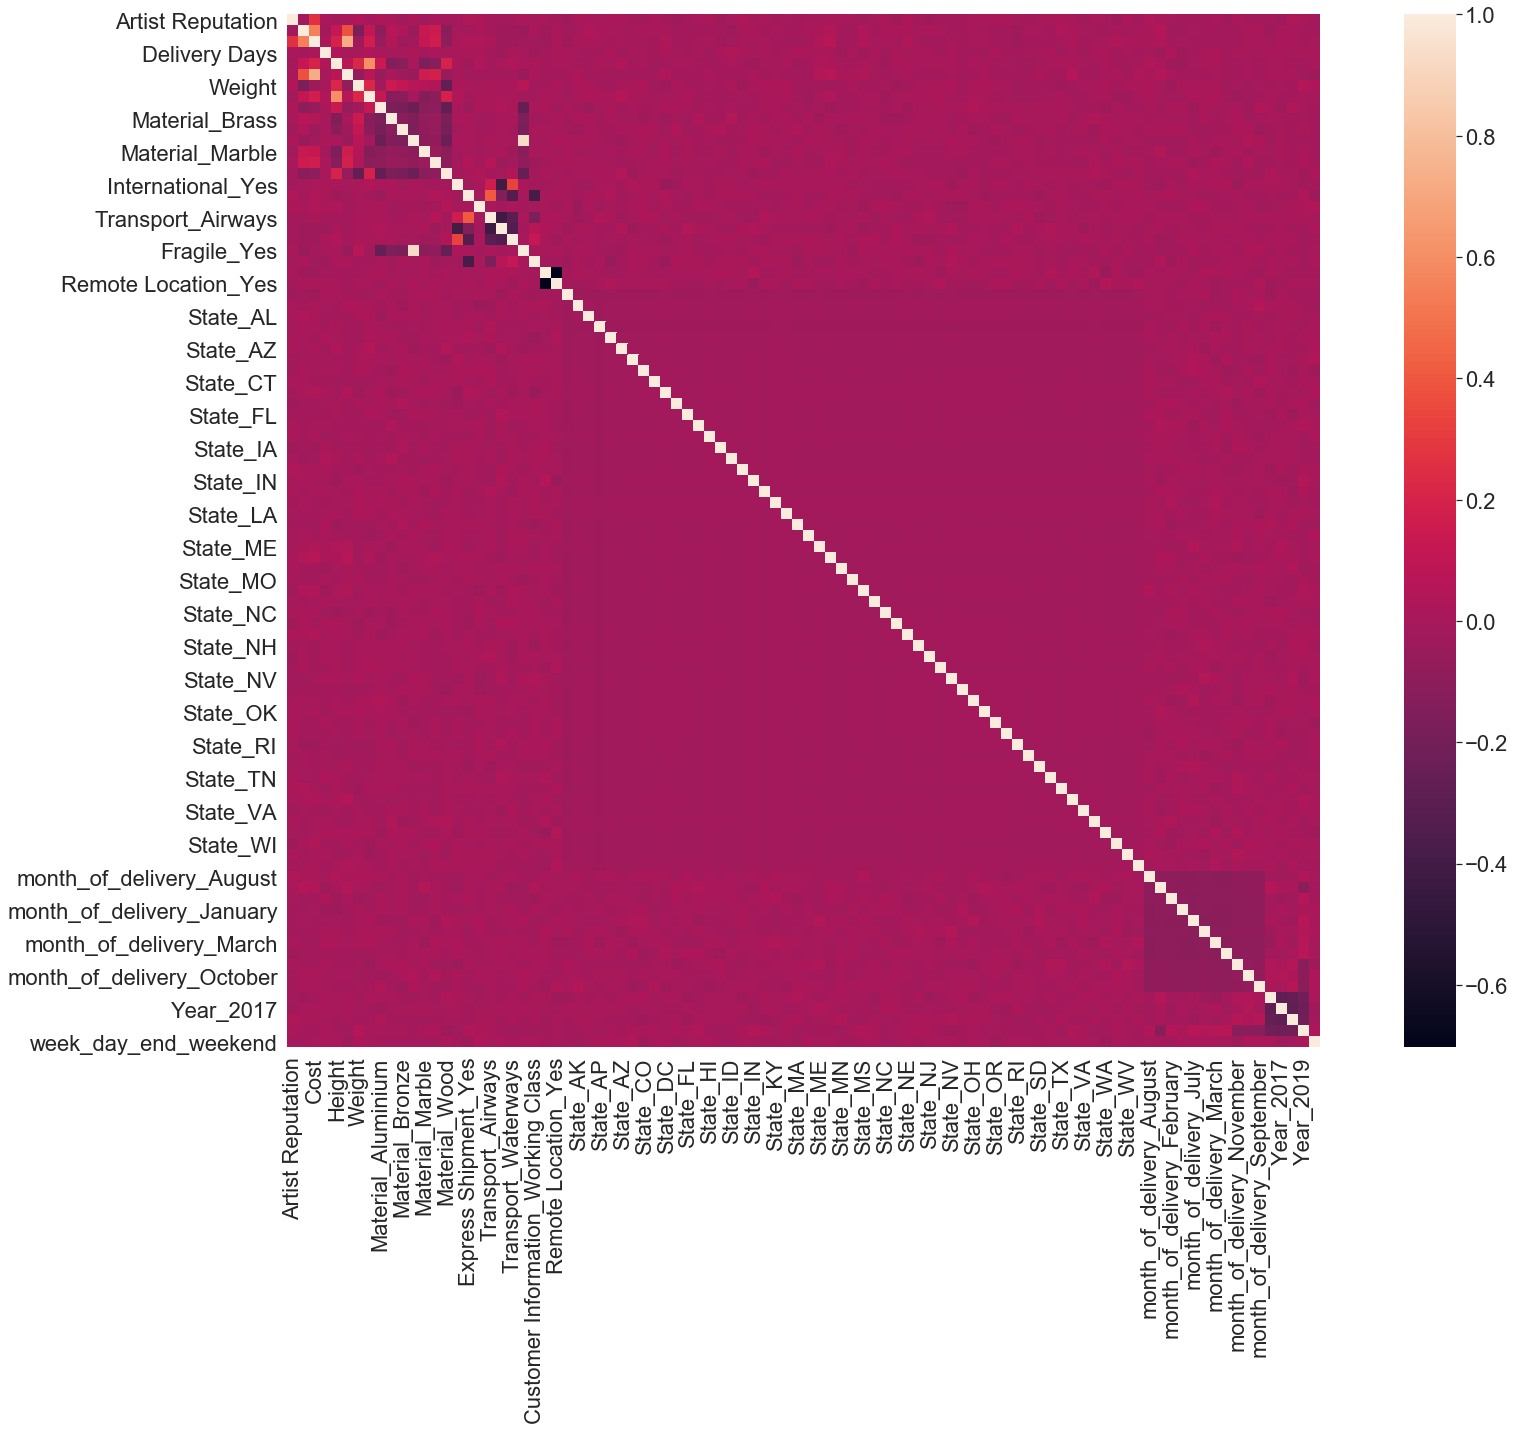

In [215]:
cor_matrix = df_train_scaler.corr()
f, ax = plt.subplots(figsize=(30, 19))
sns.set(font_scale=2)
sns.heatmap(cor_matrix,square = True)

In [216]:
pd.set_option('display.max_rows', None)
cor_matrix.Cost.sort_values(ascending = False)[0:20]

<IPython.core.display.Javascript object>

Cost                          1.000000
Price Of Sculpture            0.725475
Base Shipping Price           0.544642
Artist Reputation             0.263301
Height                        0.199693
Material_Stone                0.171263
Width                         0.164636
Material_Marble               0.125807
State_MI                      0.070617
Material_Brass                0.044930
State_WI                      0.041408
Express Shipment_Yes          0.039546
month_of_delivery_December    0.038729
State_NE                      0.038505
State_MS                      0.036992
Installation Included_Yes     0.036371
State_DC                      0.032705
State_ME                      0.031434
State_UT                      0.024018
International_Yes             0.018897
Name: Cost, dtype: float64

In [217]:
#2. Important Features 2
imp_features_2 = cor_matrix.Cost.sort_values(ascending = False)[0:20].index

In [218]:
imp_features_2

Index(['Cost', 'Price Of Sculpture', 'Base Shipping Price',
       'Artist Reputation', 'Height', 'Material_Stone', 'Width',
       'Material_Marble', 'State_MI', 'Material_Brass', 'State_WI',
       'Express Shipment_Yes', 'month_of_delivery_December', 'State_NE',
       'State_MS', 'Installation Included_Yes', 'State_DC', 'State_ME',
       'State_UT', 'International_Yes'],
      dtype='object')

In [219]:
df_train_scaler = df_train_scaler[imp_features_1]

### Model

In [220]:
#Importing all the librairies we'll need

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

scaler = MinMaxScaler()
y_train = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df_train_add['Cost'])))

y_train.columns = ['Cost']

In [221]:
X_train = df_train_scaler.drop(['Cost'], axis = 1)
y_train = df_train_scaler["Cost"]

In [222]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train,y_train,test_size = 0.3, random_state=0)

In [223]:
linreg = LinearRegression()
parameters_lin = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False]}
grid_linreg = GridSearchCV(linreg, parameters_lin, verbose = 1, scoring = "r2")
grid_linreg.fit(X_training,y_training)

print("Best Score: " + str(grid_linreg.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.6476455053898865


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [224]:
linreg = grid_linreg.best_estimator_
linreg.fit(X_training, y_training)
lin_pred = linreg.predict(X_valid)
r2_lin = r2_score(y_valid, lin_pred)
rmse_lin = np.sqrt(mean_squared_error(y_valid, lin_pred))
print("R^2 Score: " + str(r2_lin))
print("RMSE Score: " + str(rmse_lin))

<IPython.core.display.Javascript object>

R^2 Score: 0.7471745785125541
RMSE Score: 0.5392014267500909


In [225]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_valid, lin_pred))
print('MSE:', metrics.mean_squared_error(y_valid, lin_pred))

MAE: 0.24903516880083204
MSE: 0.2907381786093336


In [226]:
scores_lin = cross_val_score(linreg, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_lin)))

<IPython.core.display.Javascript object>

Cross Validation Score: 0.6599486805198439


### Xgboost

In [227]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=20000,
                       max_depth=3, 
                       min_child_weight=0,
                       gamma=0, 
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear', 
                       nthread=-1,
                       scale_pos_weight=1, 
                       seed=27,
                       reg_alpha=0.006)

In [228]:
xgb = xgboost.fit(X_training.select_dtypes([np.number]), y_training)

<IPython.core.display.Javascript object>

[01:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [229]:
xgb_pred = xgb.predict(X_valid.select_dtypes([np.number]))
r2_xgb = r2_score(y_valid, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, xgb_pred))
print("R^2 Score: " + str(r2_xgb))
print("RMSE Score: " + str(rmse_xgb))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

R^2 Score: 0.8492829234053644
RMSE Score: 0.4163148414348439


### Random Forest Regression

In [230]:
rfr = RandomForestRegressor()
paremeters_rf = {"n_estimators" : [5, 10, 15, 20], "criterion" : ["mse" , "mae"], "min_samples_split" : [2, 3, 5, 10], 
                 "max_features" : ["auto", "log2"]}
grid_rf = GridSearchCV(rfr, paremeters_rf, verbose=1, scoring="r2")
grid_rf.fit(X_training, y_training)

print("Best RandomForestRegressor Model: " + str(grid_rf.best_estimator_))
print("Best Score: " + str(grid_rf.best_score_))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
rf = grid_rf.best_estimator_
rfr.fit(X_training, y_training)
rf_pred = rfr.predict(X_valid)
r2_rf = r2_score(y_valid, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_valid, rf_pred))
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))

In [ ]:
scores_rf = cross_val_score(rfr, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_rf)))

### Test Data

In [231]:
scaler = StandardScaler()
df_train_scaler_x = pd.DataFrame(scaler.fit_transform(df_train_add[df_train_add.columns.difference(['Cost'])]))
df_train_scaler_x.columns = df_train_add[df_train_add.columns.difference(['Cost'])].columns

<IPython.core.display.Javascript object>

In [232]:
df_train_scaler_x.columns

Index(['Artist Reputation', 'Base Shipping Price',
       'Customer Information_Working Class', 'Delivery Days',
       'Express Shipment_Yes', 'Fragile_Yes', 'Height',
       'Installation Included_Yes', 'International_Yes', 'Material_Aluminium',
       'Material_Brass', 'Material_Bronze', 'Material_Clay', 'Material_Marble',
       'Material_Stone', 'Material_Wood', 'Price Of Sculpture',
       'Remote Location_No', 'Remote Location_Yes', 'State_AE', 'State_AK',
       'State_AL', 'State_AP', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
       'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI',
       'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
       'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN',
       'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE',
       'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH',
       'State_OK', 'State_OR', 'State_PA', 'State_RI', 'St

In [233]:
df_test_scaler = pd.DataFrame(scaler.transform(df_test_add))

<IPython.core.display.Javascript object>

In [234]:
df_test_scaler.columns = df_test_add.columns
df_test_scaler.columns

Index(['Artist Reputation', 'Base Shipping Price', 'Delivery Days', 'Height',
       'Price Of Sculpture', 'Weight', 'Width', 'Material_Aluminium',
       'Material_Brass', 'Material_Bronze', 'Material_Clay', 'Material_Marble',
       'Material_Stone', 'Material_Wood', 'International_Yes',
       'Express Shipment_Yes', 'Installation Included_Yes',
       'Transport_Airways', 'Transport_Roadways', 'Transport_Waterways',
       'Fragile_Yes', 'Customer Information_Working Class',
       'Remote Location_No', 'Remote Location_Yes', 'State_AE', 'State_AK',
       'State_AL', 'State_AP', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
       'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI',
       'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
       'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN',
       'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE',
       'State_NH', 'State_NJ', 'State_NM', 'S

In [235]:
imp_features_2 = list(imp_features_2)
imp_features_2.remove("Cost")
imp_features_2

['Price Of Sculpture',
 'Base Shipping Price',
 'Artist Reputation',
 'Height',
 'Material_Stone',
 'Width',
 'Material_Marble',
 'State_MI',
 'Material_Brass',
 'State_WI',
 'Express Shipment_Yes',
 'month_of_delivery_December',
 'State_NE',
 'State_MS',
 'Installation Included_Yes',
 'State_DC',
 'State_ME',
 'State_UT',
 'International_Yes']

In [236]:
scaler_y = StandardScaler()
df_train_scaler_y = pd.DataFrame(scaler_y.fit_transform(pd.DataFrame(df_train_add['Cost'])))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [237]:
submission_predictions = scaler_y.inverse_transform(xgb.predict(df_test_scaler[list(imp_coef[0:26].index)].select_dtypes([np.number])))
print(submission_predictions)

<IPython.core.display.Javascript object>

[6290.169  6033.06   5631.0864 ... 6811.8403 7163.1934 9095.435 ]


In [238]:
df_test = pd.read_csv("test.csv")

<IPython.core.display.Javascript object>

In [239]:
res=pd.DataFrame(columns = ['Customer Id', 'Cost'])
res['Customer Id'] = df_test['Customer Id']
res['Cost'] = submission_predictions
res.to_csv('submission_2021_03_07.csv',index=False)

<IPython.core.display.Javascript object>

In [240]:
df_test.columns

Index(['Customer Id', 'Artist Name', 'Artist Reputation', 'Height', 'Width',
       'Weight', 'Material', 'Price Of Sculpture', 'Base Shipping Price',
       'International', 'Express Shipment', 'Installation Included',
       'Transport', 'Fragile', 'Customer Information', 'Remote Location',
       'Scheduled Date', 'Delivery Date', 'Customer Location'],
      dtype='object')

In [ ]:
df_test_add.columns

In [ ]:
submission_predictions